## Problem Statement




The aim of this project is to develop a machine learning model that can accurately identify offensive comments on an online message board that a university in Singapore is planning to launch. The message board is intended to foster a sense of community among students, but the university is concerned about the potential for offensive comments as it may include elements of racism, sexism, or other forms of discrimination. These offensive comments can have far-reaching consequences beyond the message board itself. Negative attention from local media or other stakeholders can damage the university's reputation and put it in a negative spotlight. Hence, they have approached us to solve this issue.

To address this concern, we will collect a dataset of comments from the popular social media platform Reddit, which is similar to the message board the university plans to implement, and whose [user base largely overlaps with the university's student population](https://www.statista.com/statistics/261766/share-of-us-internet-users-who-use-reddit-by-age-group/). We will use text classification algorithms, specifically Multinomial Naive Bayes and Random Forest, to train and evaluate models on this dataset, with a focus on achieving high recall scores to accurately identify offensive comments.

We will also explore the impact of various pre-processing techniques, such as stopword removal, removing of special characters, and lemmatizing, on model performance. Finally, we will present the best performing model to the university, along with recommendations for implementation and ongoing monitoring of the message board.

Overall, the goal of this project is to provide the university with a tool to identify and address offensive comments on their online message board.

## Data Scraping from Reddit

To get my dataset, I will be scraping data from Reddit, a popular [social news aggregation, content rating, and discussion website.](https://en.wikipedia.org/wiki/Reddit) I will be using PRAW which stands for Python Reddit API Wrapper. The documentation can be found [here](https://praw.readthedocs.io/en/stable/index.html).

I aim to get around 10,000 rows for this dataset, but it can always be increased if more data is required.

It will be broken down in the following manner:

I will scrape the following 10 subreddits:
1. Politics
1. Science
1. Art
1. Music
1. Funny
1. News
1. Movies
1. Singapore
1. TodayILearned
1. NotTheOnion

These subreddits have been chosen as they are extremely popular subreddits with tens of millions of members. The exception would be the subreddit 'Singapore', I have included it to have representation in the local context and to also better fit the problem statement.

From each subreddit, I will get the 100 'hottest' posts at the time of scraping as defined by reddit's algorithm.

From these 100 hot posts, I will then get the 'best' 10 comments in the post as defined by reddit's algorithm.

This will give me 100 posts x 10 comments x 10 subreddits = 10000 rows of data

In [1]:
import praw # PRAW stands for Python Reddit API Wrapper, I will be using this to scrape reddit for data.
from tqdm import tqdm # timer to track my loops as it will take hours to scrape and classify the dataset.
from googleapiclient import discovery # API which I will be using to generate my y labels.
import langdetect # using for language detection
from langdetect.lang_detect_exception import LangDetectException # using it in a try except loop
from IPython.display import display # Used to display images
from PIL import Image #Used to display images

import praw_credentials # to hide my api key
import perspective_credentials # to hide my api key
import json
import numpy as np
import pandas as pd
import os 
import time # to wait a certain amount of time to avoid hitting quota of API

In [2]:
reddit = praw.Reddit(client_id=praw_credentials.client_id,
                     client_secret=praw_credentials.client_secret,
                     username=praw_credentials.username,
                     password=praw_credentials.password,
                     user_agent=praw_credentials.user_agent)

In [3]:
posts = []
subreddit = reddit.subreddit('singapore') # assigning a particular subreddit to my variable subreddit

for post in subreddit.hot(): #iterating through the hottest posts in the assigned subreddit
    if post.stickied or post.subreddit.display_name == "promoted": #This is to skip pinned threads and advertisements, these aren't actually user submitted posts, so I will skip them.
        continue
    post_row = [post.title, post.score, post.subreddit, post.id, post.url, post.num_comments]# assigning the various attributes of each 'post' into a list which will be my column values.
    posts.append(post_row) #appending each iteration of post_rows into my posts list, which are my data's column values
    
posts = pd.DataFrame(posts, columns=['title', 'score', 'subreddit','id', 'url', 'num_comments']) #Converting the posts list into a data frame with appropriately titled columns.
posts

,title,score,subreddit,id,url,num_comments
0,The most random thing seen today,2401,singapore,12vudx3,https://i.redd.it/45m1m99xjlva1.jpg,168
1,"M'sian man, 67, rides to S'pore at 2am twice a...",339,singapore,12vvd8f,https://mothership.sg/2023/04/malaysian-man-so...,42
2,The 5 dollar note tree,203,singapore,12vtf6g,https://i.redd.it/17dhk27edlva1.jpg,14
3,"Politically apathetic? Not us, say PAP and opp...",102,singapore,12vqv6c,https://www.straitstimes.com/singapore/politic...,90
4,Soaring COE prices: What’s driving the insanit...,41,singapore,12vwgro,https://www.straitstimes.com/singapore/transpo...,45
...,...,...,...,...,...,...
94,IKEA sells 12-inch hotdog for S$1 to celebrate...,281,singapore,12swy0o,https://mothership.sg/2023/04/ikea-12-inch-hot...,64
95,"34,000 trees planted in Jurong Island, increas...",10,singapore,12tthlu,https://www.straitstimes.com/singapore/34000-t...,4
96,Commentary: Why tropical Singapore sent an exp...,0,singapore,12ul15r,https://www.channelnewsasia.com/commentary/cli...,10
97,Giant double rainbow spotted in Singapore: How...,5,singapore,12twzgj,https://www.straitstimes.com/singapore/environ...,6


The scraping works for the posts. Now to scrape comments from within each post. To do that, I will need to expand my code and use nested loops.

In [4]:
posts = []
subreddit = reddit.subreddit('singapore') # assigning a particular subreddit to my variable subreddit.
total_rows_added = 0 #I will be using this variable to track the number of rows I have added.

for post in subreddit.hot(): #iterating through the hottest posts in the assigned subreddit.
    
    if post.stickied or post.subreddit.display_name == "promoted":#This is to skip pinned threads and advertisements, these aren't actually user submitted posts, so I will skip them.
        continue
    post_row = [post.title, post.score, post.subreddit, post.id, post.url, post.num_comments]# assigning the various attributes of each 'post' into a list which will be my column values.
        
        
    post.comments.replace_more(limit=0)# this is accessing the comments from within the post. 
    num_comments_printed = 0 # This is to track the number of comments scraped from a particular post.
    for comment in post.comments:
        if comment.stickied: #This is to skip stickied comments as it is usually a reminder about the particular subreddit's rules and not actual user submitted comments.
            continue
        num_comments_printed +=1
        comment_row = list(post_row) # make a copy of the post row for each comment so that my final dataframe will have the same values for all other features, and only the value under the comment column will change
        comment_row.append(comment.body)
        posts.append(comment_row) #appending the post attributes and the comments to posts list which will be my data values.
        if num_comments_printed == 5: # once 10 comments have been scraped from a particular post, to move on to the next post.
            break
            
    total_rows_added = len(posts) # to check how many comments have been added to the final dataset so far.
    
    if total_rows_added >= 10: # break out of the loop once the desired amount of rows have been added.
        break
        
# create dataframe
posts = pd.DataFrame(posts, columns=['title', 'score', 'subreddit','id', 'url', 'num_comments', 'comment'])
posts


,title,score,subreddit,id,url,num_comments,comment
0,The most random thing seen today,2399,singapore,12vudx3,https://i.redd.it/45m1m99xjlva1.jpg,168,Quite impressive for it to take the escalator ...
1,The most random thing seen today,2399,singapore,12vudx3,https://i.redd.it/45m1m99xjlva1.jpg,168,Spring(leaf) Chicken.
2,The most random thing seen today,2399,singapore,12vudx3,https://i.redd.it/45m1m99xjlva1.jpg,168,"""Commuters who are caught evading fares will b..."
3,The most random thing seen today,2399,singapore,12vudx3,https://i.redd.it/45m1m99xjlva1.jpg,168,Why did the chicken take the train?
4,The most random thing seen today,2399,singapore,12vudx3,https://i.redd.it/45m1m99xjlva1.jpg,168,"damn, grab delivery really upped their game in..."
5,"M'sian man, 67, rides to S'pore at 2am twice a...",343,singapore,12vvd8f,https://mothership.sg/2023/04/malaysian-man-so...,42,"Damn, dude really let his father down."
6,"M'sian man, 67, rides to S'pore at 2am twice a...",343,singapore,12vvd8f,https://mothership.sg/2023/04/malaysian-man-so...,42,If somebody makes a wrong decision in their li...
7,"M'sian man, 67, rides to S'pore at 2am twice a...",343,singapore,12vvd8f,https://mothership.sg/2023/04/malaysian-man-so...,42,Mainstream media portraying drug traffickers i...
8,"M'sian man, 67, rides to S'pore at 2am twice a...",343,singapore,12vvd8f,https://mothership.sg/2023/04/malaysian-man-so...,42,"Drugs destroy families, including the traffick..."
9,"M'sian man, 67, rides to S'pore at 2am twice a...",343,singapore,12vvd8f,https://mothership.sg/2023/04/malaysian-man-so...,42,"Drug wise, tragedy all around.\n\nI consider t..."


Scraping for comments of different posts works as well. Now to expand the code further to iterate through different subreddits and grab the corresponding posts and comments.

I will need to implement more nested loops.

In [6]:
test = ['singapore','politics','Art']
posts = []

for thing in test: # iterating over a list of subreddits
    subreddit = reddit.subreddit(thing) # assigning a particular subreddit to my variable subreddit
    comments_added = [] # I need this variable as an accumulator for number of comments added for a particular subreddit. I place it inside the loop so that it resets after the loop enters a new subreddit so that it can exit the loop at the required value again.
    total_rows_added = 0 #I will be using this variable to track the number of rows I have added to the final dataset.

    for post in subreddit.hot(): #iterating through the hottest posts in the assigned subreddit

        if post.stickied or post.subreddit.display_name == "promoted":#This is to skip pinned threads and advertisements, these aren't actually user submitted posts, so I will skip them.
            continue
        post_row = [post.title, post.score, post.subreddit, post.id, post.url, post.num_comments]# assigning the various attributes of each 'post' into a list which will be my column values.


        post.comments.replace_more(limit=0) # this is accessing the comments from within the post. 
        num_comments_printed = 0 # This is to track the number of comments scraped from a particular post.
        for comment in post.comments:
            if comment.stickied: #This is to skip stickied comments as it is usually a reminder about the particular subreddit's rules and not actual user submitted comments.
                continue
            num_comments_printed +=1
            comment_row = list(post_row)# make a copy of the post row for each comment so that my final dataframe will have the same values for all other features, and only the value under the comment column will change
            comment_row.append(comment.body)
            posts.append(comment_row) #appending the post attributes and the comments to posts list which will be my data values.
            comments_added.append(comment_row)
            if num_comments_printed == 10: # once 10 comments have been scraped from a particular post, to move on to the next post.
                break

        if len(comments_added) >= 50: # exits the loop once the desired amount of comments have been scraped from the particular subreddit
                break

        if total_rows_added >= 150: # exits the entire loop once the desired amount of rows of the final dataset has been scraped.
            break

# create dataframe
posts = pd.DataFrame(posts, columns=['title', 'score', 'subreddit','id', 'url', 'num_comments', 'comment'])
posts


,title,score,subreddit,id,url,num_comments,comment
0,The most random thing seen today,2405,singapore,12vudx3,https://i.redd.it/45m1m99xjlva1.jpg,171,Quite impressive for it to take the escalator ...
1,The most random thing seen today,2405,singapore,12vudx3,https://i.redd.it/45m1m99xjlva1.jpg,171,Spring(leaf) Chicken.
2,The most random thing seen today,2405,singapore,12vudx3,https://i.redd.it/45m1m99xjlva1.jpg,171,"""Commuters who are caught evading fares will b..."
3,The most random thing seen today,2405,singapore,12vudx3,https://i.redd.it/45m1m99xjlva1.jpg,171,Why did the chicken take the train?
4,The most random thing seen today,2405,singapore,12vudx3,https://i.redd.it/45m1m99xjlva1.jpg,171,"damn, grab delivery really upped their game in..."
...,...,...,...,...,...,...,...
149,"Ancient Astronaut, Me, 3D, 2023",1810,Art,12v9mt7,https://i.redd.it/4m10a5ztggva1.jpg,34,Oh I like this. Makes me think of Darksiders 2...
150,"Ancient Astronaut, Me, 3D, 2023",1810,Art,12v9mt7,https://i.redd.it/4m10a5ztggva1.jpg,34,Makes me want a horizon zero dawn in a differe...
151,"Ancient Astronaut, Me, 3D, 2023",1810,Art,12v9mt7,https://i.redd.it/4m10a5ztggva1.jpg,34,"I thought it was Zelda for a second there, nic..."
152,"Ancient Astronaut, Me, 3D, 2023",1810,Art,12v9mt7,https://i.redd.it/4m10a5ztggva1.jpg,34,There’s an ancient Saiyan on the loose among t...


In [10]:
posts[45:55]

,title,score,subreddit,id,url,num_comments,comment
45,Soaring COE prices: What’s driving the insanit...,39,singapore,12vwgro,https://www.straitstimes.com/singapore/transpo...,45,While I understand that cars are luxury goods ...
46,Soaring COE prices: What’s driving the insanit...,39,singapore,12vwgro,https://www.straitstimes.com/singapore/transpo...,45,Make it cash only bidding without loans. \nSep...
47,‘We couldn’t bear seeing all the kids running ...,24,singapore,12vy4cz,https://www.straitstimes.com/singapore/we-coul...,27,>‘We couldn’t bear seeing all the kids running...
48,‘We couldn’t bear seeing all the kids running ...,24,singapore,12vy4cz,https://www.straitstimes.com/singapore/we-coul...,27,Why not adopt or foster? There are [many child...
49,‘We couldn’t bear seeing all the kids running ...,24,singapore,12vy4cz,https://www.straitstimes.com/singapore/we-coul...,27,Just close ur eyes then
50,‘We couldn’t bear seeing all the kids running ...,24,singapore,12vy4cz,https://www.straitstimes.com/singapore/we-coul...,27,"Very sad to hear such experiences, and kinda s..."
51,‘We couldn’t bear seeing all the kids running ...,24,singapore,12vy4cz,https://www.straitstimes.com/singapore/we-coul...,27,Sounds kinda selfish to me. Just because they ...
52,Biden Is Winning Over More Democrats Than Obam...,7551,politics,12vtljd,https://www.newsweek.com/biden-winning-over-mo...,1219,Helps when the other side is pure fascism.
53,Biden Is Winning Over More Democrats Than Obam...,7551,politics,12vtljd,https://www.newsweek.com/biden-winning-over-mo...,1219,We know the alternative. \n\nThere’s no compar...
54,Biden Is Winning Over More Democrats Than Obam...,7551,politics,12vtljd,https://www.newsweek.com/biden-winning-over-mo...,1219,"For real, I am just terrified of the Republic..."


In [11]:
posts[95:105]

,title,score,subreddit,id,url,num_comments,comment
95,"Alaska Supreme Court, in landmark ruling, says...",33409,politics,12vafk7,https://www.adn.com/politics/2023/04/21/alaska...,582,Ohio Supreme Court said the same thing. *Five ...
96,"Alaska Supreme Court, in landmark ruling, says...",33409,politics,12vafk7,https://www.adn.com/politics/2023/04/21/alaska...,582,This is what Moore v Harper would change. If t...
97,"Alaska Supreme Court, in landmark ruling, says...",33409,politics,12vafk7,https://www.adn.com/politics/2023/04/21/alaska...,582,Now do Wisconsin.
98,"Alaska Supreme Court, in landmark ruling, says...",33409,politics,12vafk7,https://www.adn.com/politics/2023/04/21/alaska...,582,Wisconsin is next. Hopefully we'll finally get...
99,"Alaska Supreme Court, in landmark ruling, says...",33409,politics,12vafk7,https://www.adn.com/politics/2023/04/21/alaska...,582,Build Back Better addressed gerrymandering and...
100,"Alaska Supreme Court, in landmark ruling, says...",33409,politics,12vafk7,https://www.adn.com/politics/2023/04/21/alaska...,582,I've lived in Alaska for most of my adult life...
101,"Alaska Supreme Court, in landmark ruling, says...",33409,politics,12vafk7,https://www.adn.com/politics/2023/04/21/alaska...,582,Seems kinda f*ckin obvious that intentionally ...
102,"""The Rejected"", me, Pens/Copic markers/pencils...",4040,Art,12vmkmw,https://i.redd.it/7dqzcncvmiva1.jpg,116,Absurdly clean for pen and marker!
103,"""The Rejected"", me, Pens/Copic markers/pencils...",4040,Art,12vmkmw,https://i.redd.it/7dqzcncvmiva1.jpg,116,I dont know who you are but i saw that man wit...
104,"""The Rejected"", me, Pens/Copic markers/pencils...",4040,Art,12vmkmw,https://i.redd.it/7dqzcncvmiva1.jpg,116,DAMN! Good work! Im pulling for her!


Notice that the subreddit changes exactly after 50 rows.

Scraping for comments across posts across subreddits work. Now I can expand it to scrape the full amount of comments across the full list of subreddits.

The next block of code will be getting my full dataset of around 10,000 rows. This will take a bit of time. It took 30 minutes for my computer to run.

Notice that I have changed the values of if len(comments_added) >= **1000** to 1000 and if total_rows_added >= **10000** to 10000.

In [12]:
list_of_subreddits = ['politics','science','Art','Music','funny','news','movies','singapore','todayilearned','nottheonion']#implementing the full list
posts = []

for genre in tqdm(list_of_subreddits): # iterating over a list of subreddits
    subreddit = reddit.subreddit(genre) # assigning a particular subreddit to my variable subreddit
    comments_added = [] # I need this variable as an accumulator for number of comments added for a particular subreddit. I place it inside the loop so that it resets after the loop enters a new subreddit so that it can exit the loop at the required value again.
    total_rows_added = 0 #I will be using this variable to track the number of rows I have added to the final dataset.

    for post in subreddit.hot(): #iterating through the hottest posts in the assigned subreddit

        if post.stickied or post.subreddit.display_name == "promoted":#This is to skip pinned threads and advertisements, these aren't actually user submitted posts, so I will skip them.
            continue
        post_row = [post.title, post.score, post.subreddit, post.id, post.url, post.num_comments]# assigning the various attributes of each 'post' into a list which will be my column values.


        post.comments.replace_more(limit=0) # this is accessing the comments from within the post. 
        num_comments_printed = 0 # This is to track the number of comments scraped from a particular post.
        for comment in post.comments:
            if comment.stickied: #This is to skip stickied comments as it is usually a reminder about the particular subreddit's rules and not actual user submitted comments.
                continue
            num_comments_printed +=1
            comment_row = list(post_row)# make a copy of the post row for each comment so that my final dataframe will have the same values for all other features, and only the value under the comment column will change
            comment_row.append(comment.body)
            posts.append(comment_row) #appending the post attributes and the comments to posts list which will be my data values.
            comments_added.append(comment_row)
            if num_comments_printed == 10: # once 10 comments have been scraped from a particular post, to move on to the next post.
                break

        if len(comments_added) >= 1000: # exits the loop once the desired amount of comments have been scraped from the particular subreddit
                break

        if total_rows_added >= 10000: # exits the entire loop once the desired amount of rows of the final dataset has been scraped.
            break

# create dataframe
posts = pd.DataFrame(posts, columns=['title', 'score', 'subreddit','id', 'url', 'num_comments', 'comment'])
posts


100%|██████████████████████████████████████████| 10/10 [22:43<00:00, 136.35s/it]


,title,score,subreddit,id,url,num_comments,comment
0,Biden Is Winning Over More Democrats Than Obam...,7627,politics,12vtljd,https://www.newsweek.com/biden-winning-over-mo...,1226,Helps when the other side is pure fascism.
1,Biden Is Winning Over More Democrats Than Obam...,7627,politics,12vtljd,https://www.newsweek.com/biden-winning-over-mo...,1226,We know the alternative. \n\nThere’s no compar...
2,Biden Is Winning Over More Democrats Than Obam...,7627,politics,12vtljd,https://www.newsweek.com/biden-winning-over-mo...,1226,"For real, I am just terrified of the Republic..."
3,Biden Is Winning Over More Democrats Than Obam...,7627,politics,12vtljd,https://www.newsweek.com/biden-winning-over-mo...,1226,Biden sure wasn't my favourite in the primarie...
4,Biden Is Winning Over More Democrats Than Obam...,7627,politics,12vtljd,https://www.newsweek.com/biden-winning-over-mo...,1226,>President Joe Biden currently has a higher jo...
...,...,...,...,...,...,...,...
6257,New Jersey Environmental Agency fines itself f...,145,nottheonion,12pqg6l,https://tvpworld.com/69221279/new-jersey-envir...,8,If they're holding themselves accountable that...
6258,New Jersey Environmental Agency fines itself f...,145,nottheonion,12pqg6l,https://tvpworld.com/69221279/new-jersey-envir...,8,At least they are honest.
6259,New Jersey Environmental Agency fines itself f...,145,nottheonion,12pqg6l,https://tvpworld.com/69221279/new-jersey-envir...,8,I knew I saw this earlier\n\nr/nottheonion/com...
6260,New Jersey Environmental Agency fines itself f...,145,nottheonion,12pqg6l,https://tvpworld.com/69221279/new-jersey-envir...,8,A governmental agency fining itself is in effe...


In [13]:
posts['subreddit'].unique()

array([Subreddit(display_name='politics'),
       Subreddit(display_name='science'), Subreddit(display_name='Art'),
       Subreddit(display_name='Music'), Subreddit(display_name='funny'),
       Subreddit(display_name='news'), Subreddit(display_name='movies'),
       Subreddit(display_name='singapore'),
       Subreddit(display_name='todayilearned'),
       Subreddit(display_name='nottheonion')], dtype=object)

Notice that the DataFrame has less than 10,000 rows. The reason is that certain posts had less than 10 comments inside the post. As such for that particular post, less than 10 comments were scraped.

This compounded over all the subreddits and all the posts, resulted in only 6262 rows.

I will need to scrape more subreddits for more data.

In [14]:
#posts.to_csv('../data/outputs/comments_from_reddit_part_1.csv') #exporting posts dataframe into csv

In [25]:
list_of_subreddits_2 = ['gaming','AskReddit','aww','Showerthoughts','sports','food','worldnews','pics']#implementing a new list of subreddits to scrape data

posts_2 = [] # initialising a different list called posts_2 for clarity

for genre in tqdm(list_of_subreddits_2): # iterating over a list of subreddits
    subreddit = reddit.subreddit(genre) # assigning a particular subreddit to my variable subreddit
    comments_added = [] # I need this variable as an accumulator for number of comments added for a particular subreddit. I place it inside the loop so that it resets after the loop enters a new subreddit so that it can exit the loop at the required value again.
    total_rows_added = 0 #I will be using this variable to track the number of rows I have added to the final dataset.

    for post in subreddit.hot(): #iterating through the hottest posts in the assigned subreddit

        if post.stickied or post.subreddit.display_name == "promoted":#This is to skip pinned threads and advertisements, these aren't actually user submitted posts, so I will skip them.
            continue
        post_row = [post.title, post.score, post.subreddit, post.id, post.url, post.num_comments]# assigning the various attributes of each 'post' into a list which will be my column values.


        post.comments.replace_more(limit=0) # this is accessing the comments from within the post. 
        num_comments_printed = 0 # This is to track the number of comments scraped from a particular post.
        for comment in post.comments:
            if comment.stickied: #This is to skip stickied comments as it is usually a reminder about the particular subreddit's rules and not actual user submitted comments.
                continue
            num_comments_printed +=1
            comment_row = list(post_row)# make a copy of the post row for each comment so that my final dataframe will have the same values for all other features, and only the value under the comment column will change
            comment_row.append(comment.body)
            posts_2.append(comment_row) #appending the post attributes and the comments to posts list which will be my data values.
            comments_added.append(comment_row)
            if num_comments_printed == 10: # once 10 comments have been scraped from a particular post, to move on to the next post.
                break

        if len(comments_added) >= 1000: # exits the loop once the desired amount of comments have been scraped from the particular subreddit
                break

        if total_rows_added >= 10000: # exits the entire loop once the desired amount of rows of the final dataset has been scraped.
            break

# create dataframe
posts_2 = pd.DataFrame(posts_2, columns=['title', 'score', 'subreddit','id', 'url', 'num_comments', 'comment'])
posts_2


100%|████████████████████████████████████████████| 8/8 [15:52<00:00, 119.01s/it]


,title,score,subreddit,id,url,num_comments,comment
0,Not enough people know about Tribes,4668,gaming,12vsse6,https://i.imgur.com/bY6EIbq.jpg,748,Shazbot!
1,Not enough people know about Tribes,4668,gaming,12vsse6,https://i.imgur.com/bY6EIbq.jpg,748,"Man, skiing over a map, grabbing the flag, and..."
2,Not enough people know about Tribes,4668,gaming,12vsse6,https://i.imgur.com/bY6EIbq.jpg,748,"Bro, I miss Tribes: Ascend\n\nSHAZBOT!"
3,Not enough people know about Tribes,4668,gaming,12vsse6,https://i.imgur.com/bY6EIbq.jpg,748,I'll never forgive hi Rez for killing this IP
4,Not enough people know about Tribes,4668,gaming,12vsse6,https://i.imgur.com/bY6EIbq.jpg,748,"Fun game, lost in time"
...,...,...,...,...,...,...,...
4456,New personal trainer challenge: I finished my ...,8,pics,12vyrny,https://i.redd.it/inn9aqu4ykva1.jpg,10,"Confidence, love to see it"
4457,New personal trainer challenge: I finished my ...,8,pics,12vyrny,https://i.redd.it/inn9aqu4ykva1.jpg,10,I seriously hope its not for self defense.
4458,New personal trainer challenge: I finished my ...,8,pics,12vyrny,https://i.redd.it/inn9aqu4ykva1.jpg,10,At one point OP will be required to shout \nTH...
4459,Wreckage of an American B17 in remote Papua Ne...,36,pics,12vnw31,https://i.redd.it/apsoza6sckva1.jpg,3,Was literally just talking about my grandfathe...


In [38]:
#posts_2.to_csv('../data/outputs/comments_from_reddit_part_2.csv') #exporting posts dataframe into csv

In [44]:
final_posts = pd.concat([posts,posts_2])

Concatenating both dataframes together.

In [46]:
final_posts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10723 entries, 0 to 4460
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         10723 non-null  object
 1   score         10723 non-null  int64 
 2   subreddit     10723 non-null  object
 3   id            10723 non-null  object
 4   url           10723 non-null  object
 5   num_comments  10723 non-null  int64 
 6   comment       10723 non-null  object
dtypes: int64(2), object(5)
memory usage: 670.2+ KB


Final Dataset with over 10,000 rows.

## Classifiying the Scraped Data

Now that I have my dataset, I need to get my y labels based on the comments.

To do this, I will be using [Google's Perspective API](https://developers.perspectiveapi.com/s/about-the-api?language=en_US), which is an API that uses machine learning to analyse text and returns a probability that the text is of one of certain attributes such as toxic, insulting, threatening, etc.

The full list of attributes and documentation can be found [here.](https://developers.perspectiveapi.com/s/about-the-api-attributes-and-languages?language=en_US)

Next I will run through code to show how it works on a small scale, before running it through all 9000+ rows of my dataset.

In [47]:
API_KEY = perspective_credentials.API_KEY

client = discovery.build(
  "commentanalyzer",
  "v1alpha1",
  developerKey=API_KEY,
  discoveryServiceUrl="https://commentanalyzer.googleapis.com/$discovery/rest?version=v1alpha1",
  static_discovery=False,
)

analyze_request = {
  'comment': { 'text': 'testing text to check for toxicity' },
  'requestedAttributes': {'TOXICITY': {}}
}

response = client.comments().analyze(body=analyze_request).execute()
print(json.dumps(response, indent=2))

{
  "attributeScores": {
    "TOXICITY": {
      "spanScores": [
        {
          "begin": 0,
          "end": 34,
          "score": {
            "value": 0.050573748,
            "type": "PROBABILITY"
          }
        }
      ],
      "summaryScore": {
        "value": 0.050573748,
        "type": "PROBABILITY"
      }
    }
  },
  "languages": [
    "en"
  ],
  "detectedLanguages": [
    "en"
  ]
}


This block of code has been copied from [Perspective's documentation](https://developers.perspectiveapi.com/s/docs-sample-requests?language=en_US) of sample requests.

The important portion for me is under 'comment' where I will input my list of comments to get a probability for the attributes under 'requestedAttributes', in this block of code, the requested attribute is 'TOXICITY'.

From the output, you can see under 'summaryScore' a value of 0.05 which is the probability score between 0 to 1 that the input text is toxic or whatever attribute you selected.

A higher score indicates a higher probability that the input text is the attribute you selected.

In [48]:
response['attributeScores']['TOXICITY']['summaryScore']['value']

0.050573748

I have filtered out the probablity value as this is what I will be basing my y labels off of.

Now I can set a threshold and check for all the attributes I want to generate my y labels

In [49]:
attributes = ['TOXICITY', 'IDENTITY_ATTACK', 'INSULT', 'PROFANITY', 'THREAT']
y_label = []
for comment in final_posts.iloc[:20]['comment']:
    analyze_request = {
        'comment': { 'text': comment },
        'requestedAttributes': {   #Note that more attributes have been requested
            'TOXICITY': {},
            'IDENTITY_ATTACK': {},
            'INSULT': {},
            'PROFANITY': {},
            'THREAT': {},
        }
    }
    response = client.comments().analyze(body=analyze_request).execute()
    scores = [response['attributeScores'][attr]['summaryScore']['value'] for attr in attributes] # list comprehension to run through my list of attributes and storing all scores in a list
    y_label.append(1 if any(score >= 0.5 for score in scores) else 0) # checking through the list of scores if any are above 0.5, if it is label it as a 1, if not label as 0.

In this block of code, I have expanded it to check for more attributes besides TOXICITY, I have also set the threshold at 0.5. Any comment which scores above 0.5 for any of the attributes will be classified as offensive and the value will be 1.

In [50]:
y_label

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]

Here are my y labels for the first 20 rows of my dataset. 

## Checking Classifications against Human Labelled

To check the accuracy of the perspective API, I will be manually labelling 100 comments to compare results.

I will be checking for the following, as described in the [documentation](https://developers.perspectiveapi.com/s/about-the-api-attributes-and-languages?language=en_US): 

1. IDENTITY_ATTACK: Negative or hateful comments targeting someone because of their identity.

1. INSULT: Insulting, inflammatory, or negative comment towards a person or a group of people.

1. PROFANITY: Swear words, curse words, or other obscene or profane language.

1. THREAT Describes an intention to inflict pain, injury, or violence against an individual or group.

In [65]:
final_posts.iloc[:100]['comment'] # These are the 100 comments I will hand label.

0                                                                                                                                                                                                                                                                                                  Helps when the other side is pure fascism.
1                                                                                                 We know the alternative. \n\nThere’s no comparison. \n\nRun of the mill democrat vs “holy fucking shit, I can’t do this again” \n\nGotta take back that House. I’m getting real sick of McCarthy and the imbecile gang he pretends to lead.
2                                                                                                                                                          For real,  I am just terrified of the Republicans at this point. Stripping people of their rights is not the right approach to country where people are safe and mentally healthy

In [64]:
hand_labelled = [0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0]

I went through these 100 comments and hand labelled them, 1 being offensive, 0 not being offensive. The hand labelled classifications can be found above. 

I can now compare it against the API generated y labels.

In [67]:
attributes = ['TOXICITY', 'IDENTITY_ATTACK', 'INSULT', 'PROFANITY', 'THREAT']
y_label = []
counter = 0
for comment in final_posts.iloc[0:100]['comment']:
    analyze_request = {
        'comment': { 'text': comment },
        'requestedAttributes': {   #Note that more attributes have been requested
            'TOXICITY': {},
            'IDENTITY_ATTACK': {},
            'INSULT': {},
            'PROFANITY': {},
            'THREAT': {},
        }
    }
    response = client.comments().analyze(body=analyze_request).execute()
    scores = [response['attributeScores'][attr]['summaryScore']['value'] for attr in attributes] # list comprehension to run through my list of attributes and storing all scores in a list
    y_label.append(1 if any(score >= 0.5 for score in scores) else 0) # checking through the list of scores if any are above 0.5, if it is label it as a 1, if not label as 0.
    counter +=1
    if counter % 50 == 0: # Wait one minute every 50 comments to avoid hitting the quota
        time.sleep(60) 

**Note the important additions in the above block of code.**

1. Initialising a counter variable
1. To wait 60 seconds after every 50 comments analysed.

This is as Perspective has a quota limit of 60 per minute, if I exceed this quota, my code will error out. To stay on the safe side, I will wait 1 minute every 50 comments to let the quota reest, before analysing the next 50 comments.

With this quota in place, it is going to take an extremely long time to analyse the full dataset, but I will get to that later.

I will first check the 100 generated labels against my hand labelled data.

In [68]:
y_label

[0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

Here are the API generated y labels for the first 100 comments. I can now check this against my hand labelled values.

In [69]:
matches = 0
for i in range(len(hand_labelled)):
    if hand_labelled[i] == y_label[i]:
        matches += 1
        
similarity = matches / len(hand_labelled) * 100
print(f"Percentage of similarity: {similarity:.2f}%")

Percentage of similarity: 90.00%


There is a 90% similarity between my hand labelled data and the machine labelled data. I think this is a pretty good score, and this means I can continue with using the machine generated labels for the rest of my dataset.

## Generating Labels for Full Dataset

Now I will run the code to generate y labels for my entire dataset. Note that this will take around 3 - 4 hours barring any unforeseen errors.

In [70]:
len(final_posts.iloc[:]['comment'])

10723

**Please expand the markdown text below, it shows the code I tried to run, I put it back into markdown text to avoid any accidental running of a codeblock which will error out. The explanation is further below.**

attributes = ['TOXICITY', 'IDENTITY_ATTACK', 'INSULT', 'PROFANITY', 'THREAT']
y_label = []
counter = 0
for comment in tqdm(final_posts.iloc[:]['comment']):
    analyze_request = {
        'comment': { 'text': comment },
        'requestedAttributes': {   #Note that more attributes have been requested
            'TOXICITY': {},
            'IDENTITY_ATTACK': {},
            'INSULT': {},
            'PROFANITY': {},
            'THREAT': {},
        }
    }
    response = client.comments().analyze(body=analyze_request).execute()
    scores = [response['attributeScores'][attr]['summaryScore']['value'] for attr in attributes] # list comprehension to run through my list of attributes and storing all scores in a list
    y_label.append(1 if any(score >= 0.5 for score in scores) else 0) # checking through the list of scores if any are above 0.5, if it is label it as a 1, if not label as 0.
    counter +=1
    if counter % 50 == 0: # Wait one minute every 50 comments to avoid hitting the quota
        time.sleep(60) 

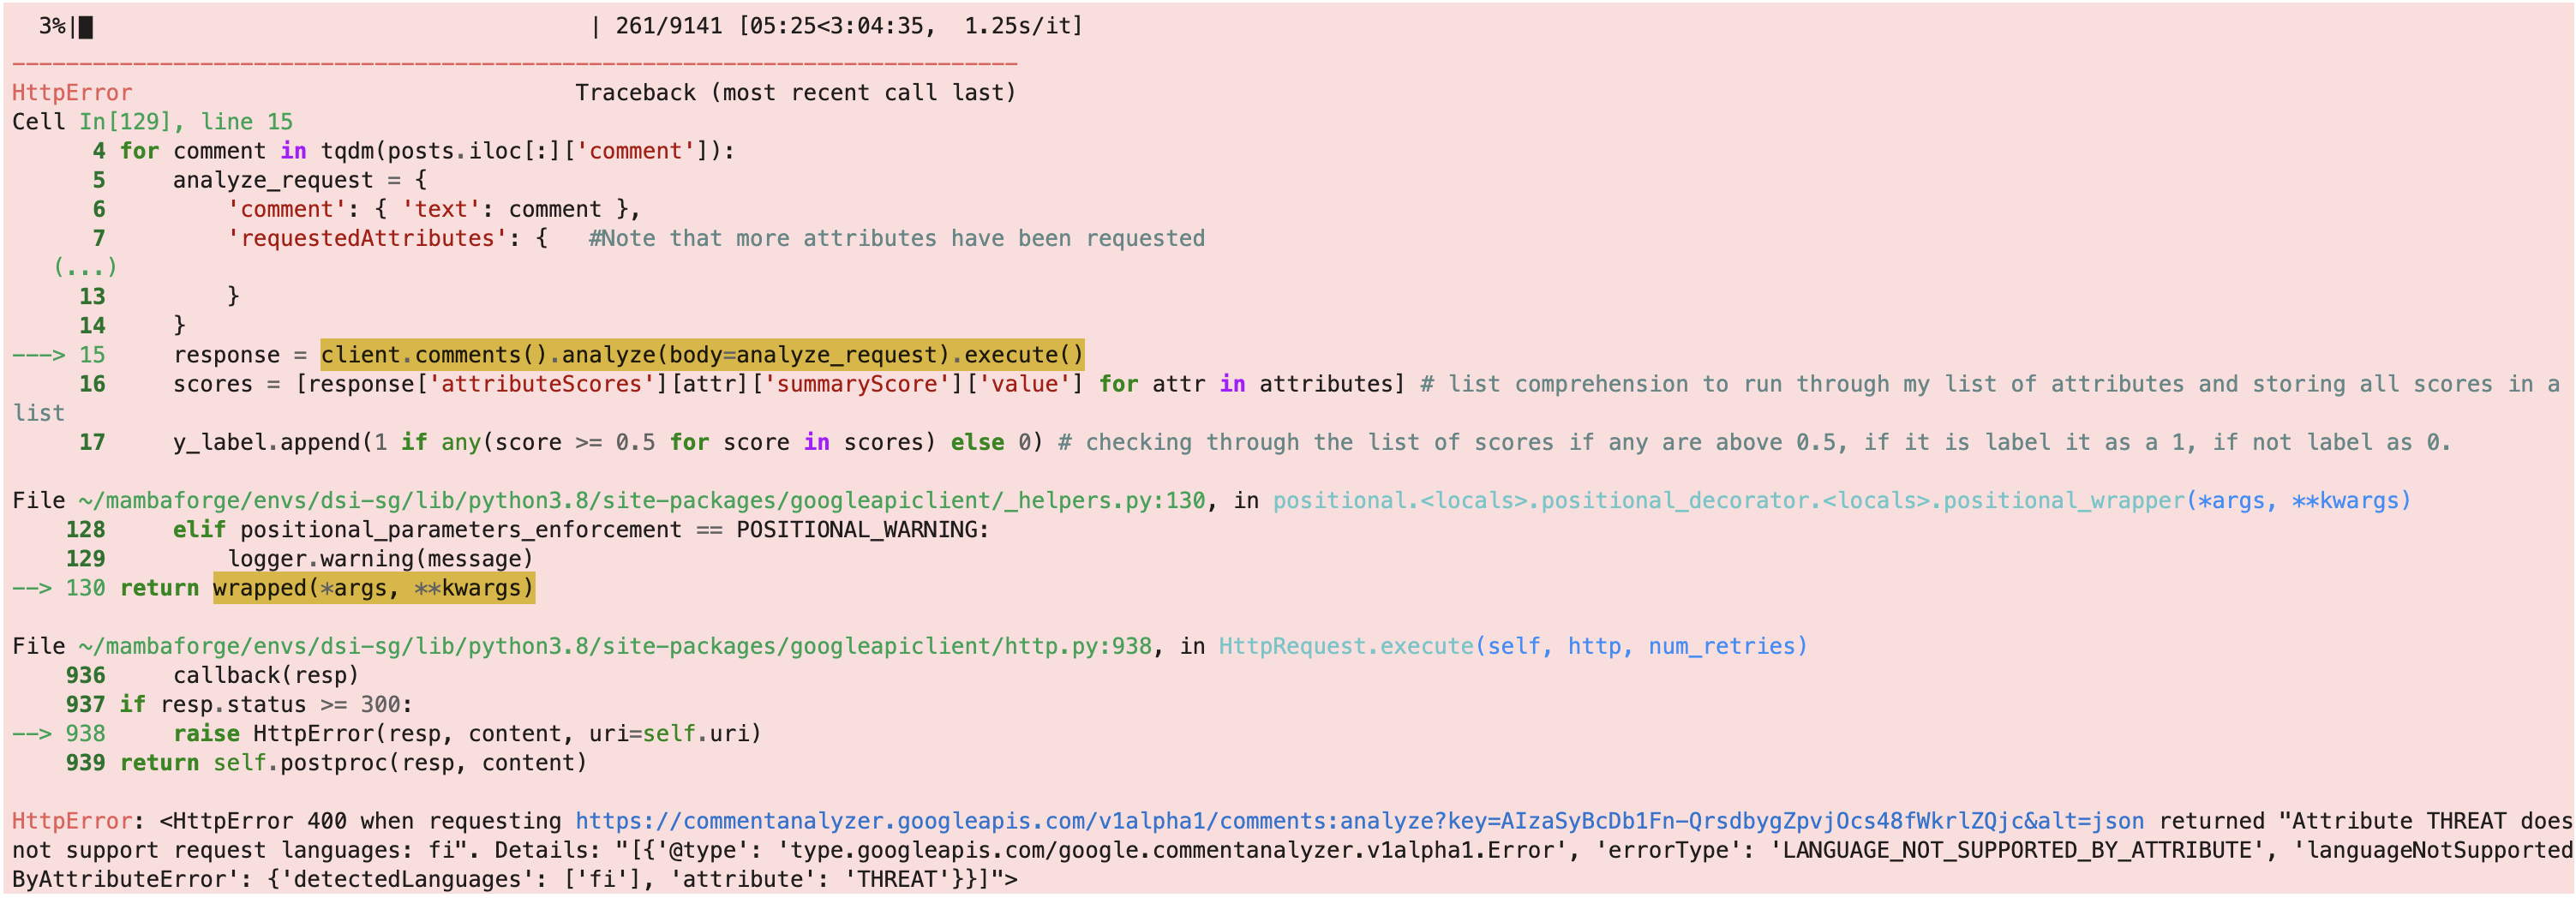

In [177]:
path="../images/error_code.png"
display(Image.open(path))

Unfortunately the code block threw an error as shown in the image above.

A certain comment was not in english as decided by the API's language detection and threw an error.

I will need to amend the code to check for the language type before passing it to the analyser to avoid any more errors.


I found out that [Perspective API uses language detection](https://developers.perspectiveapi.com/s/about-the-api-methods?language=en_US) from Google's Cloud Natural Language API. However, this API requires money so I won't be using the same language detection model.

As such, I will use another language detection(listed below) in a try except loop for each comment before passing it to the actual comment analyser to try and reduce the number of language errors. This is not ideal as they will have different algorithms to detect language, but this is the best alternative under the given circumstances.


I will also include code to save the generated y labels up to that point in case of any other unforeseen errors so I don't need to run the entire loop over and over again for every error, but rather I can work on the next checkpoint.


**This is the module I will be using for language detection**

#pip install langdetect

#import langdetect

#from langdetect.lang_detect_exception import LangDetectException

In [71]:
output_file = os.path.join('../data/outputs/', 'y_label.npy')

Creating a outputfile to save the generated y labels up to that point.

**Worst case scenario, I will need to keep running the loop from each error point and updating the y labels until I finish all the rows. This is still significantly faster than reading each comment one at a time**

In [72]:
attributes = ['TOXICITY', 'IDENTITY_ATTACK', 'INSULT', 'PROFANITY', 'THREAT']
y_label = []
counter = 0
for comment in tqdm(final_posts.iloc[:]['comment']):
    try:
        if langdetect.detect(comment) != 'en': # if the comment is not in English, append NaN to y_label
            y_label.append(float('nan'))
            continue
    except LangDetectException: # if it is in English, run the rest of the loop
        pass
    
    analyze_request = {
        'comment': { 'text': comment },
        'languages': ['en'],
        'requestedAttributes': {
            'TOXICITY': {},
            'IDENTITY_ATTACK': {},
            'INSULT': {},
            'PROFANITY': {},
            'THREAT': {},
        }
    }
    
    response = client.comments().analyze(body=analyze_request).execute()
    scores = [response['attributeScores'][attr]['summaryScore']['value'] for attr in attributes]# list comprehension to run through my list of attributes and storing all scores in a list
    y_label.append(1 if any(score >= 0.5 for score in scores) else 0)# checking through the list of scores if any are above 0.5, if it is label it as a 1, if not label as 0.
    counter +=1
    if counter % 50 == 0: # Wait one minute every 50 comments to avoid hitting the quota
        time.sleep(60)
        
    np.save(output_file, y_label)# Save the generated y labels to a file so I don't lose progress, and I can also use the generated file to see which comment threw the error.

100%|███████████████████████████████████| 10723/10723 [3:34:44<00:00,  1.20s/it]


**Luckily, the code did not encounter any errors this time. The code has finally finished running. It took over 3 hours. Time to inspect the y_label**

In [73]:
len(y_label)

10723

10723 Labels as expected.

## Checking for Missing Values

In [77]:
final_posts['target'] = y_label # adding labels to dataframe.

In [78]:
final_posts['target'].unique()

array([ 0.,  1., nan])

Notice that there are null values due to the language detection.

I will now check these rows to see if they really were not in english. If they were wrongly classified, I will manually label these rows if the numbers are manageable.

In [79]:
final_posts[final_posts['target'].isnull()]

,title,score,subreddit,id,url,num_comments,comment,target
39,"Ron DeSantis promises to boycott Bud Light before admitting he prefers LGBTQ+-friendly Guinness. DeSantis said that Bud Light ""lost a customer"" and then admitted he doesn't even drink it.",8816,politics,12vfywb,https://www.lgbtqnation.com/2023/04/ron-desantis-promises-to-boycott-bud-light-before-admitting-he-prefers-lgbtq-friendly-guinness/,700,Florida lost me as a customer.,NaN
55,The Texas Senate Just Voted To Destroy Its Public Universities,5296,politics,12vip2v,https://talkingpointsmemo.com/morning-memo/texas-senate-tenure-bill-public-universities,382,[removed],NaN
77,Tennessee Republican who voted to expel Democrats resigns after ethics violation,2974,politics,12vlj9r,https://www.nbcnews.com/politics/politics-news/tennessee-republican-lawmaker-resigns-ethics-violation-rcna80782,47,Good.,NaN
161,Meet the Afghanistan War Veteran Taking on Rep. George Santos,1140,politics,12vk986,https://www.msnbc.com/jonathan-capehart/watch/meet-the-afghanistan-war-veteran-taking-on-rep-george-santos-171012165896,46,George Santos.. didn’t he die on 9/11?,NaN
188,"Minnesota Senate passes bill banning conversion “therapy”. “If anyone doubts that we can take meaningful action to protect our kids, I’ve got two words for you: Watch us.” ~ Gov. Tim Walz",2366,politics,12vd8bl,https://www.losangelesblade.com/2023/04/21/minnesota-senate-passes-bill-banning-conversion-therapy/,79,"Go Walz, keep it up!",NaN
...,...,...,...,...,...,...,...,...
4404,Beach House,101,pics,12vgalt,https://i.redd.it/651amnswkhva1.jpg,30,Extremely motivated seller...,NaN
4427,Wife and I checked something off the bucket list ✅ Sunrise over the Himalayas. 🥲,60,pics,12vkq8z,https://i.redd.it/nvynrb3btjva1.jpg,7,[removed],NaN
4428,Wife and I checked something off the bucket list ✅ Sunrise over the Himalayas. 🥲,60,pics,12vkq8z,https://i.redd.it/nvynrb3btjva1.jpg,7,Beautiful,NaN
4432,Protesting Ron DeSantis at Utah Valley University,68,pics,12viqpx,https://i.redd.it/n07ucshnhjva1.jpg,2,Dancing is forbidden,NaN


There are 915 rows of null values. I'll take a closer look.

In [80]:
final_posts[final_posts['target'].isnull()]['comment'].value_counts()

[removed]                 75
[deleted]                 48
adorable                  11
Awww cute                 10
super cute                 7
                          ..
I stand alone              1
/r/titlegore               1
So no A2M?                 1
Star Lord?                 1
Looks like a fun class     1
Name: comment, Length: 734, dtype: int64

The top two null values are due to comments having been deleted or removed. I will drop these rows.

In [81]:
final_posts = final_posts[~((final_posts['target'].isnull()) & (final_posts['comment'] == '[deleted]'))]

In [82]:
final_posts = final_posts[~((final_posts['target'].isnull()) & (final_posts['comment'] == '[removed]'))]

I have dropped deleted and removed comments

In [86]:
missing_values = final_posts[final_posts['target'].isnull()]
missing_values

,title,score,subreddit,id,url,num_comments,comment,target
39,"Ron DeSantis promises to boycott Bud Light before admitting he prefers LGBTQ+-friendly Guinness. DeSantis said that Bud Light ""lost a customer"" and then admitted he doesn't even drink it.",8816,politics,12vfywb,https://www.lgbtqnation.com/2023/04/ron-desantis-promises-to-boycott-bud-light-before-admitting-he-prefers-lgbtq-friendly-guinness/,700,Florida lost me as a customer.,NaN
77,Tennessee Republican who voted to expel Democrats resigns after ethics violation,2974,politics,12vlj9r,https://www.nbcnews.com/politics/politics-news/tennessee-republican-lawmaker-resigns-ethics-violation-rcna80782,47,Good.,NaN
161,Meet the Afghanistan War Veteran Taking on Rep. George Santos,1140,politics,12vk986,https://www.msnbc.com/jonathan-capehart/watch/meet-the-afghanistan-war-veteran-taking-on-rep-george-santos-171012165896,46,George Santos.. didn’t he die on 9/11?,NaN
188,"Minnesota Senate passes bill banning conversion “therapy”. “If anyone doubts that we can take meaningful action to protect our kids, I’ve got two words for you: Watch us.” ~ Gov. Tim Walz",2366,politics,12vd8bl,https://www.losangelesblade.com/2023/04/21/minnesota-senate-passes-bill-banning-conversion-therapy/,79,"Go Walz, keep it up!",NaN
223,Minnesota Senate Passes Bill To Ban 'Conversion Therapy' For LGBTQ+ People,1068,politics,12vkc9z,https://www.huffpost.com/entry/minnesota-lgbtq-so-called-conversion-therapy-ban_n_644431b5e4b039ec4e7f1d50,35,Michelle Bachmann in shambles.,NaN
...,...,...,...,...,...,...,...,...
4394,"Crafted from a whiskey barrel, an old guitar string, and silver.",38,pics,12vq1dc,https://i.redd.it/kjudt264rkva1.jpg,9,Nice,NaN
4404,Beach House,101,pics,12vgalt,https://i.redd.it/651amnswkhva1.jpg,30,Extremely motivated seller...,NaN
4428,Wife and I checked something off the bucket list ✅ Sunrise over the Himalayas. 🥲,60,pics,12vkq8z,https://i.redd.it/nvynrb3btjva1.jpg,7,Beautiful,NaN
4432,Protesting Ron DeSantis at Utah Valley University,68,pics,12viqpx,https://i.redd.it/n07ucshnhjva1.jpg,2,Dancing is forbidden,NaN


Remaining null rows. It looks like all of the comments are in English, which means that the language detection module I used didn't identify these ones correctly. I will run these commemnts through the analyser another time and join the results back to my dataframe.

In [96]:
attributes = ['TOXICITY', 'IDENTITY_ATTACK', 'INSULT', 'PROFANITY', 'THREAT']
y_label_for_null_values = []
counter = 0
for comment in tqdm(missing_values['comment']):
    analyze_request = {
        'comment': { 'text': comment },
        'languages': ['en'],
        'requestedAttributes': {   #Note that more attributes have been requested
            'TOXICITY': {},
            'IDENTITY_ATTACK': {},
            'INSULT': {},
            'PROFANITY': {},
            'THREAT': {},
        }
    }
    response = client.comments().analyze(body=analyze_request).execute()
    scores = [response['attributeScores'][attr]['summaryScore']['value'] for attr in attributes] # list comprehension to run through my list of attributes and storing all scores in a list
    y_label_for_null_values.append(1 if any(score >= 0.5 for score in scores) else 0) # checking through the list of scores if any are above 0.5, if it is label it as a 1, if not label as 0.
    counter +=1
    if counter % 50 == 0: # Wait one minute every 50 comments to avoid hitting the quota
        time.sleep(60) 

100%|█████████████████████████████████████████| 792/792 [16:13<00:00,  1.23s/it]


In [98]:
len(y_label_for_null_values)

792

Got the y labels for the null values.

In [105]:
final_posts.loc[final_posts['target'].isnull(), 'target'] = y_label_for_null_values

In [106]:
final_posts.isnull().sum()

title           0
score           0
subreddit       0
id              0
url             0
num_comments    0
comment         0
target          0
dtype: int64

In [107]:
final_posts['target'].unique()

array([0., 1.])

In [113]:
final_posts['target'] = final_posts['target'].astype(int)

Now let's check to see whether my labels are balanced or imbalanced. If they are imbalanced, I may need to scrape for more data from reddits which are more likely to have offensive statements.

In [130]:
final_posts['target'].value_counts(normalize=True)

0    0.900689
1    0.099311
Name: target, dtype: float64

## Imbalanced y Classes, Scraping for more Data

Unfortunately my y labels are heavily imbalanced. I will need to scrape more data to make the classes more balanced.

I will scrape from subreddits which I think are more offensive in nature to get more 1 y labels. I will also scrape more posts and more comments per subreddit for this reason as well.

In [133]:
list_of_subreddits_3 = ['PublicFreakout','antiwork','SubredditDrama','facepalm','entitledparents']#implementing a new list of subreddits to scrape data

posts_3 = [] # initialising a different list called posts_3 for clarity

for genre in tqdm(list_of_subreddits_3): # iterating over a list of subreddits
    subreddit = reddit.subreddit(genre) # assigning a particular subreddit to my variable subreddit
    comments_added = [] # I need this variable as an accumulator for number of comments added for a particular subreddit. I place it inside the loop so that it resets after the loop enters a new subreddit so that it can exit the loop at the required value again.
    total_rows_added = 0 #I will be using this variable to track the number of rows I have added to the final dataset.

    for post in subreddit.hot(): #iterating through the hottest posts in the assigned subreddit

        if post.stickied or post.subreddit.display_name == "promoted":#This is to skip pinned threads and advertisements, these aren't actually user submitted posts, so I will skip them.
            continue
        post_row = [post.title, post.score, post.subreddit, post.id, post.url, post.num_comments]# assigning the various attributes of each 'post' into a list which will be my column values.


        post.comments.replace_more(limit=0) # this is accessing the comments from within the post. 
        num_comments_printed = 0 # This is to track the number of comments scraped from a particular post.
        for comment in post.comments:
            if comment.stickied: #This is to skip stickied comments as it is usually a reminder about the particular subreddit's rules and not actual user submitted comments.
                continue
            num_comments_printed +=1
            comment_row = list(post_row)# make a copy of the post row for each comment so that my final dataframe will have the same values for all other features, and only the value under the comment column will change
            comment_row.append(comment.body)
            posts_3.append(comment_row) #appending the post attributes and the comments to posts list which will be my data values.
            comments_added.append(comment_row)
            if num_comments_printed == 100: # once 10 comments have been scraped from a particular post, to move on to the next post.
                break

        if len(comments_added) >= 2000: # exits the loop once the desired amount of comments have been scraped from the particular subreddit
                break

        if total_rows_added >= 15000: # exits the entire loop once the desired amount of rows of the final dataset has been scraped.
            break

# create dataframe
posts_3 = pd.DataFrame(posts_3, columns=['title', 'score', 'subreddit','id', 'url', 'num_comments', 'comment'])
posts_3


100%|█████████████████████████████████████████████| 5/5 [06:42<00:00, 80.51s/it]


,title,score,subreddit,id,url,num_comments,comment
0,Ivanka Trump being loudly booed by a man in a blue shirt,8000,PublicFreakout,12xwt77,https://v.redd.it/jcugezm0fwva1,490,"""You're the only one here.""\n\nSo you agree? The popular vote matters most?"
1,Ivanka Trump being loudly booed by a man in a blue shirt,8000,PublicFreakout,12xwt77,https://v.redd.it/jcugezm0fwva1,490,![gif](giphy|3otPotmw1yvxkfowBq|downsized)\n\nReminds me of this scene
2,Ivanka Trump being loudly booed by a man in a blue shirt,8000,PublicFreakout,12xwt77,https://v.redd.it/jcugezm0fwva1,490,They should all be shamed and ostracized in public. All the time. Every time
3,Ivanka Trump being loudly booed by a man in a blue shirt,8000,PublicFreakout,12xwt77,https://v.redd.it/jcugezm0fwva1,490,Only one there with the right attitude
4,Ivanka Trump being loudly booed by a man in a blue shirt,8000,PublicFreakout,12xwt77,https://v.redd.it/jcugezm0fwva1,490,"That is going to happen to her for the rest of her life,"
...,...,...,...,...,...,...,...
10113,Mom wants stepdad to adopt me so she can inherit me,3055,entitledparents,12km7ji,https://www.reddit.com/r/entitledparents/comments/12km7ji/mom_wants_stepdad_to_adopt_me_so_she_can_inherit/,392,Doesn't sound line you have anything in inherit \n\n\nThat sounds like needless psychotic behavior on her part
10114,Mom wants stepdad to adopt me so she can inherit me,3055,entitledparents,12km7ji,https://www.reddit.com/r/entitledparents/comments/12km7ji/mom_wants_stepdad_to_adopt_me_so_she_can_inherit/,392,Why is she so concerned about you dying? Do you have terminal cancer? Are you a millionaire? Do you have a huge life insurance policy?
10115,Mom wants stepdad to adopt me so she can inherit me,3055,entitledparents,12km7ji,https://www.reddit.com/r/entitledparents/comments/12km7ji/mom_wants_stepdad_to_adopt_me_so_she_can_inherit/,392,Is it even possible for your stepdad to adopt you if your dad is still alive and doesn’t volunteer to give up his parental rights?
10116,Mom wants stepdad to adopt me so she can inherit me,3055,entitledparents,12km7ji,https://www.reddit.com/r/entitledparents/comments/12km7ji/mom_wants_stepdad_to_adopt_me_so_she_can_inherit/,392,"""Burn me with all my stuff! It's mine!""\n\n^ My cousins actual notarized will"


In [134]:
#posts_3.to_csv('../data/outputs/comments_from_reddit_part_3.csv') #exporting posts dataframe into csv

Now to repeat the labelling process again. At this point in time I received approval from the google perspective team to increase my quota. So I can analyse more comments before waiting 1 minute. The quota was increased from 60 comments per minute to 240 comments per minute. I will now wait 60 seconds after every 230 comments insteaed of every 50 comments.

In [179]:
output_file = os.path.join('../data/outputs/', 'y_label_posts_3.npy')

Updating output_file for the new y labels.

In [137]:
attributes = ['TOXICITY', 'IDENTITY_ATTACK', 'INSULT', 'PROFANITY', 'THREAT']
y_label_posts_3 = []
counter = 0
for comment in tqdm(posts_3.iloc[:]['comment']):
    try:
        if langdetect.detect(comment) != 'en': # if the comment is not in English, append NaN to y_label
            y_label_posts_3.append(float('nan'))
            continue
    except LangDetectException: # if it is in English, run the rest of the loop
        pass
    
    analyze_request = {
        'comment': { 'text': comment },
        'languages': ['en'],
        'requestedAttributes': {
            'TOXICITY': {},
            'IDENTITY_ATTACK': {},
            'INSULT': {},
            'PROFANITY': {},
            'THREAT': {},
        }
    }
    
    response = client.comments().analyze(body=analyze_request).execute()
    scores = [response['attributeScores'][attr]['summaryScore']['value'] for attr in attributes]# list comprehension to run through my list of attributes and storing all scores in a list
    y_label_posts_3.append(1 if any(score >= 0.5 for score in scores) else 0)# checking through the list of scores if any are above 0.5, if it is label it as a 1, if not label as 0.
    counter +=1
    if counter % 230 == 0: # Wait one minute every 50 comments to avoid hitting the quota
        time.sleep(60)
        
    np.save(output_file, y_label_posts_3)# Save the generated y labels to a file so I don't lose progress, and I can also use the generated file to see which comment threw the error.

100%|█████████████████████████████████████| 10118/10118 [58:35<00:00,  2.88it/s]


In [139]:
len(y_label_posts_3)

10118

In [143]:
pd.DataFrame(y_label_posts_3).value_counts(normalize=True)

0.0    0.788713
1.0    0.211287
dtype: float64

The y labels for this set of data is still imbalanced but better than the previous dataset. In any case, I can always utilise downsampling and upsampling later on to make the dataset more balanced.

I will now redo all the steps of checking for null values, etc. before concatenating the two datasets together for my final dataset.

In [145]:
posts_3.head()

,title,score,subreddit,id,url,num_comments,comment,target
0,Ivanka Trump being loudly booed by a man in a blue shirt,8000,PublicFreakout,12xwt77,https://v.redd.it/jcugezm0fwva1,490,"""You're the only one here.""\n\nSo you agree? The popular vote matters most?",0.0
1,Ivanka Trump being loudly booed by a man in a blue shirt,8000,PublicFreakout,12xwt77,https://v.redd.it/jcugezm0fwva1,490,![gif](giphy|3otPotmw1yvxkfowBq|downsized)\n\nReminds me of this scene,0.0
2,Ivanka Trump being loudly booed by a man in a blue shirt,8000,PublicFreakout,12xwt77,https://v.redd.it/jcugezm0fwva1,490,They should all be shamed and ostracized in public. All the time. Every time,0.0
3,Ivanka Trump being loudly booed by a man in a blue shirt,8000,PublicFreakout,12xwt77,https://v.redd.it/jcugezm0fwva1,490,Only one there with the right attitude,0.0
4,Ivanka Trump being loudly booed by a man in a blue shirt,8000,PublicFreakout,12xwt77,https://v.redd.it/jcugezm0fwva1,490,"That is going to happen to her for the rest of her life,",0.0


In [144]:
posts_3['target'] = y_label_posts_3 # adding labels to dataframe.

In [146]:
posts_3['target'].unique()

array([ 0.,  1., nan])

In [147]:
posts_3[posts_3['target'].isnull()]

,title,score,subreddit,id,url,num_comments,comment,target
12,Ivanka Trump being loudly booed by a man in a blue shirt,8000,PublicFreakout,12xwt77,https://v.redd.it/jcugezm0fwva1,490,"""Woo go Trump!"" 🤮",NaN
15,Ivanka Trump being loudly booed by a man in a blue shirt,8000,PublicFreakout,12xwt77,https://v.redd.it/jcugezm0fwva1,490,Impressive lungs,NaN
29,Ivanka Trump being loudly booed by a man in a blue shirt,8000,PublicFreakout,12xwt77,https://v.redd.it/jcugezm0fwva1,490,Hahahahahahahahahahahaha,NaN
30,Ivanka Trump being loudly booed by a man in a blue shirt,8000,PublicFreakout,12xwt77,https://v.redd.it/jcugezm0fwva1,490,Booooo booo lol,NaN
31,Ivanka Trump being loudly booed by a man in a blue shirt,8000,PublicFreakout,12xwt77,https://v.redd.it/jcugezm0fwva1,490,![gif](giphy|4gZKpjp9zlsqs),NaN
...,...,...,...,...,...,...,...,...
9924,Parents force me and my brother to eat expired food,955,entitledparents,12lvyrj,https://www.reddit.com/r/entitledparents/comments/12lvyrj/parents_force_me_and_my_brother_to_eat_expired/,170,“No.” Is a complete sentence.,NaN
9997,Karen called the cops on my service dog and accused me of being too young to be disabled again,3020,entitledparents,12kqo29,https://www.reddit.com/r/entitledparents/comments/12kqo29/karen_called_the_cops_on_my_service_dog_and/,157,[removed],NaN
10004,Karen called the cops on my service dog and accused me of being too young to be disabled again,3020,entitledparents,12kqo29,https://www.reddit.com/r/entitledparents/comments/12kqo29/karen_called_the_cops_on_my_service_dog_and/,157,… again?!,NaN
10047,Mom wants stepdad to adopt me so she can inherit me,3055,entitledparents,12km7ji,https://www.reddit.com/r/entitledparents/comments/12km7ji/mom_wants_stepdad_to_adopt_me_so_she_can_inherit/,392,"nu vet jag inte vart i skandinavien du är, men är du i sverige så kan du göra alla utom dina barn arvslösa, även dina föräldrar",NaN


In [148]:
posts_3[posts_3['target'].isnull()]['comment'].value_counts()

[deleted]                                       48
Updateme!                                       45
[removed]                                       38
UpdateMe!                                       11
Updateme                                         5
                                                ..
Beautiful language                               1
![gif](giphy|13NUOwOLq0NJug)                     1
Someone has seen In Bruges                       1
![gif](giphy|DB2oahQFa0qeQ)                      1
I had no idea you could adopt a legal adult.     1
Name: comment, Length: 484, dtype: int64

The top few null values are not useful. I will remove these comments.

In [151]:
posts_3 = posts_3[~((posts_3['target'].isnull()) & (posts_3['comment'] == '[deleted]'))]

In [152]:
posts_3 = posts_3[~((posts_3['target'].isnull()) & (posts_3['comment'] == '[removed]'))]

In [153]:
posts_3 = posts_3[~((posts_3['target'].isnull()) & (posts_3['comment'] == 'Updateme!'))]

In [154]:
posts_3 = posts_3[~((posts_3['target'].isnull()) & (posts_3['comment'] == 'UpdateMe!'))]

In [155]:
posts_3 = posts_3[~((posts_3['target'].isnull()) & (posts_3['comment'] == 'Updateme'))]

In [157]:
posts_3 = posts_3[~((posts_3['target'].isnull()) & (posts_3['comment'] == 'Update me!'))]

In [158]:
posts_3 = posts_3[~((posts_3['target'].isnull()) & (posts_3['comment'] == 'Update me'))]

I have dropped deleted and removed the top few non useful comments.

In [160]:
posts_3[posts_3['target'].isnull()]

,title,score,subreddit,id,url,num_comments,comment,target
12,Ivanka Trump being loudly booed by a man in a blue shirt,8000,PublicFreakout,12xwt77,https://v.redd.it/jcugezm0fwva1,490,"""Woo go Trump!"" 🤮",NaN
15,Ivanka Trump being loudly booed by a man in a blue shirt,8000,PublicFreakout,12xwt77,https://v.redd.it/jcugezm0fwva1,490,Impressive lungs,NaN
29,Ivanka Trump being loudly booed by a man in a blue shirt,8000,PublicFreakout,12xwt77,https://v.redd.it/jcugezm0fwva1,490,Hahahahahahahahahahahaha,NaN
30,Ivanka Trump being loudly booed by a man in a blue shirt,8000,PublicFreakout,12xwt77,https://v.redd.it/jcugezm0fwva1,490,Booooo booo lol,NaN
31,Ivanka Trump being loudly booed by a man in a blue shirt,8000,PublicFreakout,12xwt77,https://v.redd.it/jcugezm0fwva1,490,![gif](giphy|4gZKpjp9zlsqs),NaN
...,...,...,...,...,...,...,...,...
9917,Parents force me and my brother to eat expired food,955,entitledparents,12lvyrj,https://www.reddit.com/r/entitledparents/comments/12lvyrj/parents_force_me_and_my_brother_to_eat_expired/,170,How many days past expiration date?,NaN
9924,Parents force me and my brother to eat expired food,955,entitledparents,12lvyrj,https://www.reddit.com/r/entitledparents/comments/12lvyrj/parents_force_me_and_my_brother_to_eat_expired/,170,“No.” Is a complete sentence.,NaN
10004,Karen called the cops on my service dog and accused me of being too young to be disabled again,3020,entitledparents,12kqo29,https://www.reddit.com/r/entitledparents/comments/12kqo29/karen_called_the_cops_on_my_service_dog_and/,157,… again?!,NaN
10047,Mom wants stepdad to adopt me so she can inherit me,3055,entitledparents,12km7ji,https://www.reddit.com/r/entitledparents/comments/12km7ji/mom_wants_stepdad_to_adopt_me_so_she_can_inherit/,392,"nu vet jag inte vart i skandinavien du är, men är du i sverige så kan du göra alla utom dina barn arvslösa, även dina föräldrar",NaN


Remaining null rows for this dataset, this time I will simply drop these rows, as I already have quite a lot of rows of data and going through a few of these comments, they are all not likely to give me the y label of 1 that I hope to get.

In [163]:
posts_3 = posts_3.dropna()

In [168]:
final_posts = pd.concat([final_posts,posts_3])

Updating the final_posts variable to include this newly scraped dataset.

In [169]:
final_posts.isnull().sum()

title           0
score           0
subreddit       0
id              0
url             0
num_comments    0
comment         0
target          0
dtype: int64

In [170]:
final_posts['target'].unique()

array([0., 1.])

In [171]:
final_posts['target'] = final_posts['target'].astype(int)

Now let's check to see whether my labels are balanced or imbalanced. If they are imbalanced, I may need to scrape for more data from reddits which are more likely to have offensive statements.

In [172]:
final_posts['target'].value_counts(normalize=True)

0    0.847806
1    0.152194
Name: target, dtype: float64

Now my y labels are slightly more balanced from 9% to 15%.

In [173]:
final_posts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20073 entries, 0 to 10117
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         20073 non-null  object
 1   score         20073 non-null  int64 
 2   subreddit     20073 non-null  object
 3   id            20073 non-null  object
 4   url           20073 non-null  object
 5   num_comments  20073 non-null  int64 
 6   comment       20073 non-null  object
 7   target        20073 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 1.4+ MB


No more null values for the target column and no null values in any of the columns.

## Checking for Duplicated Data

In [174]:
len(final_posts.columns) == len(set(final_posts.columns)) # If it is true it means there are no columns with duplicated names, if it is False, there are columns with the same names

True

No duplicated columns

In [175]:
len(final_posts[final_posts.duplicated()])

11

There are duplicated rows. I will remove these rows.

In [176]:
final_posts = final_posts[~(final_posts.duplicated())]

No duplicated rows or columns left in dataset. The dataset is fully cleaned and ready for eda and preprocessing now.

In [178]:
#final_posts.to_csv('../data/outputs/Final_DataFrame_with_ylabels.csv') #exporting final dataframe into csv

This is the end of this notebook. The next notebook will go through EDA, preprocessing, and modelling.